# Importing libraries

In [1]:
import tensorflow as tf

from keras import models, layers

import matplotlib.pyplot as plt

import numpy as np

import cv2

In [2]:
# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Available GPU: {gpus}")
else:
    print("No GPU available.")

Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import os

os.listdir('/kaggle/input/fer2013/train/happy')[:10]

['Training_65647822.jpg',
 'Training_6949915.jpg',
 'Training_16474445.jpg',
 'Training_56050083.jpg',
 'Training_17268365.jpg',
 'Training_45115516.jpg',
 'Training_4185635.jpg',
 'Training_34273117.jpg',
 'Training_99278519.jpg',
 'Training_31588747.jpg']

# Setting up the Constants

Image size:  (48, 48)


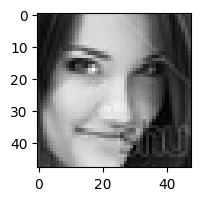

In [5]:
plt.figure(figsize=(2,2))

img = cv2.imread('/kaggle/input/fer2013/train/happy/Training_99278519.jpg', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')

img_size = img.shape

print('Image size: ',img_size)

In [6]:
BATCH_SIZE = 32

IMAGE_SIZE = img_size

CHANNELS=1

EPOCHS=50



print(f'Batch size: {BATCH_SIZE}')

print(f'Image size: {IMAGE_SIZE}')

print(f'Channels: {CHANNELS}')

print(f'Epochs: {EPOCHS}')

Batch size: 32
Image size: (48, 48)
Channels: 1
Epochs: 50


# Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [7]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(

    '/kaggle/input/fer2013/train',

    shuffle=True,

    image_size=img_size,

    batch_size=BATCH_SIZE,

    seed=10,

    color_mode='grayscale'  # Load images as grayscale

    )


Found 28709 files belonging to 7 classes.


In [8]:
dataset_test = tf.keras.preprocessing.image_dataset_from_directory(

    '/kaggle/input/fer2013/test',

    shuffle=True,

    image_size=img_size,

    batch_size=BATCH_SIZE,

    seed=10,

    color_mode='grayscale'  # Load images as grayscale

    )

Found 7178 files belonging to 7 classes.


- Total images are 35,887 so it has a ratio of 80% training data and 20& test data.

In [9]:
class_names = dataset_train.class_names

class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [10]:
y_label = []
for image_batch, labels_batch in dataset_train:
    y_label += list(labels_batch.numpy())

In [11]:
len(y_label)

28709

In [12]:
from sklearn.utils import class_weight
import numpy as np

# Assuming y_train contains your training labels
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_label),
    y=y_label
)
class_weights
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
class_weight_dict

{0: 1.0266046844269623,
 1: 9.406618610747051,
 2: 1.0010460615781582,
 3: 0.5684387684387684,
 4: 0.8260394187886635,
 5: 0.8491274770777877,
 6: 1.293372978330405}

In [13]:
for image_batch, labels_batch in dataset_train.take(1):

    print(image_batch.shape)

    print(labels_batch.numpy())

(32, 48, 48, 1)
[4 3 2 6 5 5 5 3 3 5 6 5 3 2 5 3 0 2 4 2 0 3 4 0 2 3 3 4 0 3 2 3]


## Visualize some of the images.

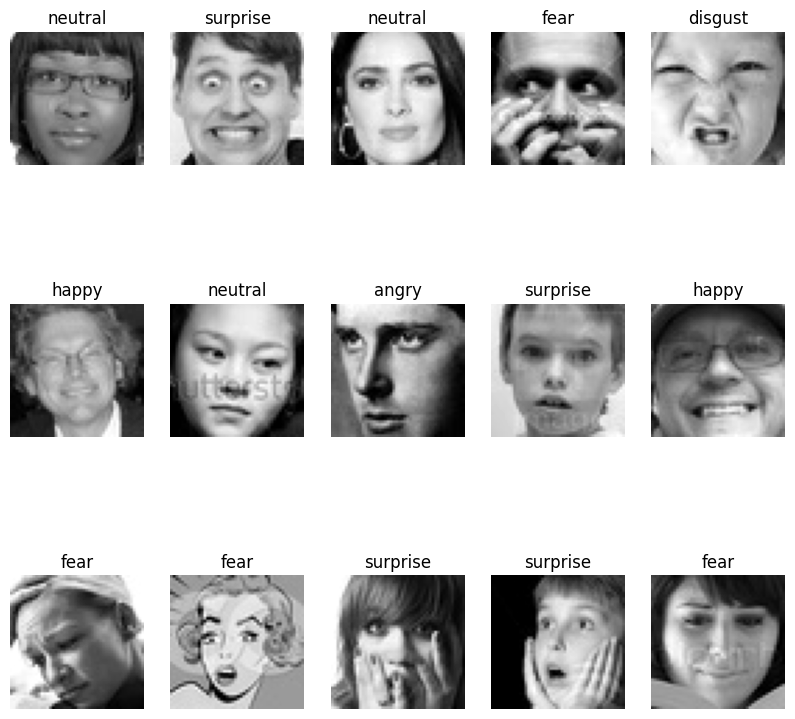

In [15]:
plt.figure(figsize=(10, 10))



for image_batch, labels_batch in dataset_train.take(1):

    for i in range(15):

        ax = plt.subplot(3, 5, i + 1)

        plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray')

        plt.title(class_names[labels_batch[i]])

        plt.axis("off")

## Spliting Dataset

Dataset should be bifurcated into 3 subsets, namely:



- Training: Dataset to be used while training

- Validation: Dataset to be tested against while training

- Test: Dataset to be tested against after we trained a 



As data is already splitted into train and test set, we will further split the test set into validation and test set.

In [16]:
len(dataset_train)

898

In [17]:
len(dataset_test)

225

In [18]:
validation_test_ratio = 0.5



len(dataset_test) * validation_test_ratio

112.5

In [19]:
len(dataset_test)

225

In [20]:
def split_test_evaluation(dataset, validation_test_ratio = 0.5, shuffle=True):



    if shuffle:

        dataset = dataset.shuffle(10000, seed=10)



    test_size = int(len(dataset) * validation_test_ratio)

    test_ds = dataset.take(test_size)

    val_ds = dataset.skip(test_size)



    return test_ds, val_ds

In [21]:
dataset_test, dataset_validation = split_test_evaluation(dataset_test)

In [22]:
len(dataset_test)

112

In [23]:
len(dataset_validation)

113

## Cache, Shuffle, and Prefetch the Dataset

In [24]:
train_ds = dataset_train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = dataset_validation.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = dataset_test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
for image_batch, labels_batch in train_ds.take(1):

    print(image_batch[0].shape)

    print(labels_batch[0].numpy())

(48, 48, 1)
0


In [26]:
IMAGE_SIZE

(48, 48)

## Building the Model

Creating a Layer for Resizing, GrayScale Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.



You might be thinking why do we need to resize (48,48) image to again (48,48). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (48,48) and this layer will resize it.

In [27]:
resize_and_rescale = tf.keras.Sequential([

  layers.Resizing(48, 48),

  layers.Rescaling(1./255),

])


In [28]:
data_augmentation = tf.keras.Sequential([

    # Data augmentation layers
    layers.RandomFlip("horizontal"),  # Randomly flip images horizontally
    layers.RandomRotation(0.1),       # Randomly rotate images by 10%
    layers.RandomZoom(0.1),           # Randomly zoom images by 10%
    layers.RandomTranslation(0.1, 0.1) # Randomly shift images by 10% horizontally and vertically
])

## Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.



We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [29]:
len(class_names)

7

In [30]:
BATCH_SIZE

32

In [119]:
input_shape = (BATCH_SIZE, 48, 48, 1)  # Grayscale images with size 48x48 and 1 channel

n_classes = len(class_names)



# model = models.Sequential([

#     resize_and_rescale,  # Assuming this step is needed for preprocessing
#     data_augmentation,

#     # First Convolutional Block
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1), data_format="channels_last"),
#     layers.BatchNormalization(),
#     layers.Conv2D(64, (3, 3), activation='relu', data_format="channels_last"),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2), data_format="channels_last"),
#     layers.Dropout(0.25),

#     # Second Convolutional Block
#     layers.Conv2D(128, (3, 3), activation='relu', data_format="channels_last"),
#     layers.BatchNormalization(),
#     layers.Conv2D(128, (3, 3), activation='relu', data_format="channels_last"),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2), data_format="channels_last"),
#     layers.Dropout(0.25),

#     # Third Convolutional Block
#     layers.Conv2D(256, (3, 3), activation='relu', data_format="channels_last"),
#     layers.BatchNormalization(),
#     layers.Conv2D(256, (3, 3), activation='relu', data_format="channels_last"),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D(pool_size=(2, 2), data_format="channels_last"),
#     layers.Dropout(0.25),

#     # Flatten the output of the conv layers for Dense layers
#     layers.Flatten(),

#     # Dense Block
#     layers.Dense(256, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.5),

#     # Output Layer
#     layers.Dense(7, activation='softmax') 
# ])





model = models.Sequential([

    resize_and_rescale,
    # First Convolutional Block
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # Second Convolutional Block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # Third Convolutional Block
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),
    
    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Output Layer for Classification
    layers.Dense(n_classes, activation='softmax'),
])
    



model.build(input_shape=input_shape)

In [120]:
model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 48, 48, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_147 (Conv2D)             │ (32, 48, 48, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_192         │ (32, 48, 48, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_148 (Conv2D)             │ (32, 48, 48, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_193         │ (32, 48, 48, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (32, 24, 24, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (32, 24, 24, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_149 (Conv2D)             │ (32, 24, 24, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_194         │ (32, 24, 24, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_150 (Conv2D)             │ (32, 24, 24, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_195         │ (32, 24, 24, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (32, 12, 12, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (32, 12, 12, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_151 (Conv2D)             │ (32, 12, 12, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_196         │ (32, 12, 12, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_152 (Conv2D)             │ (32, 12, 12, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_197         │ (32, 12, 12, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (32, 6, 6, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (32, 6, 6, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (32, 4608)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (32, 128)              │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_198         │ (32, 128)              │           51

 Total params: 887,655 (3.39 MB)

 Trainable params: 886,375 (3.38 MB)

 Non-trainable params: 1,280 (5.00 KB)

## Compiling the Model



We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [121]:
model.compile(

    optimizer='adam',

    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),

    metrics=['accuracy']

)

In [122]:
from tensorflow.keras.callbacks import EarlyStopping

# Code for early stopping if model not improves after some consecutive epochs to avoid overfitting.
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=5,           # Stop if no improvement for 3 consecutive epochs
    min_delta=0.001,      # Consider significant improvement if change > 0.001
    restore_best_weights=True, # Restore best weights at the end
    verbose=1             # Print when early stopping is triggered
)

## Training Model

In [123]:
cnn_model = model.fit(

    train_ds,

    batch_size=BATCH_SIZE,

    validation_data=val_ds,

    verbose=1,

    epochs=50,

    callbacks=[early_stopping]

)

Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.2108 - loss: 2.3165 - val_accuracy: 0.3339 - val_loss: 1.7167
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3898 - loss: 1.5629 - val_accuracy: 0.4841 - val_loss: 1.3500
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4673 - loss: 1.3911 - val_accuracy: 0.4891 - val_loss: 1.3203
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4928 - loss: 1.3283 - val_accuracy: 0.5239 - val_loss: 1.2486
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5339 - loss: 1.2454 - val_accuracy: 0.5420 - val_loss: 1.2083
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5519 - loss: 1.1898 - val_accuracy: 0.5543 - val_loss: 1.1589
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5753 - loss: 1.1423 - val_accuracy: 0.5748 - val_loss: 1.1180
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5863 - loss: 1.1104 - val_accuracy

# Evaluating Model on Test Set

In [124]:
scores = model.evaluate(test_ds)

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6290 - loss: 1.0206


In [107]:
# Accuracy and Loss Plots

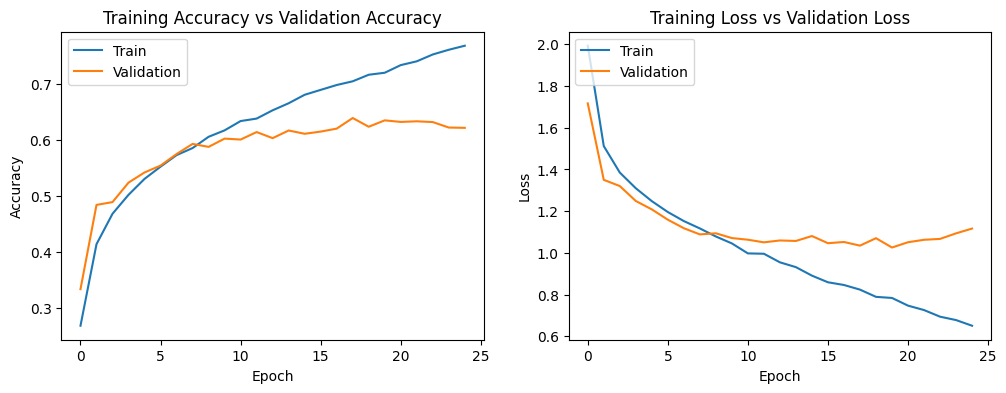

In [125]:
fig , ax = plt.subplots(1,2)
train_acc = cnn_model.history['accuracy']
train_loss = cnn_model.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(cnn_model.history['accuracy'])
ax[0].plot(cnn_model.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(cnn_model.history['loss'])
ax[1].plot(cnn_model.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

first image to predict
actual label: sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
predicted label: sad


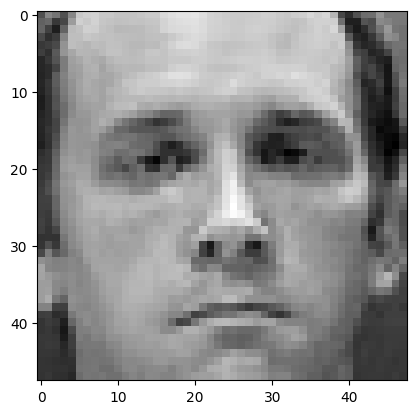

In [126]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image, cmap='gray')
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
